# Tags sugestion Stack Overflow

In this project we will create simple tag suggestion models for Stack Overflow questions.
It will be multilabels classification where models could return one or more tags for each post.

---

01. <a href="#1-Import-and-cleaning-data">Import and cleaning data</a>  
    1.1 <a href="#1.1-Tag-processing">Tag processing</a>  
    1.2 <a href="#1.2-Corpus-processing">Corpus processing</a>  
02. <a href="#2-Unsupervised-models">Unsupervised models</a>  
03. <a href="#3-Semi-supervised-models">Semi-supervised models</a>  
04. <a href="#4-Supervised-models">Supervised models</a>   
05.  <a href="#5-Conclusion"> Conclusion</a>



Tag suggestion models for StackOverflow posts.  
- Jupyter notebook [here](https://nbviewer.jupyter.org/github/Umercia/NLP_Stackoverflow/blob/master/NLP_stackoverflow_2.ipynb)
- Tool [here](http://umercia.pythonanywhere.com/) (might not be valide anymore)

---
**Data:**
In this dataset, you are provided with question titles, content, and tags for Stack Overflow site on a variety of coding topics. The content of each question is given as HTML. The tags are words or phrases that describe the topic of the question.
For each question in the test set, you should use the title and question content in order to generate potential tags.  
Source of data [here](https://data.stackexchange.com/stackoverflow/query/new)    
  
  
SQL request:   
   <code>SELECT Id, Body, Title, Tags, LastActivityDate, Score FROM Posts WHERE LastActivityDate > '01/01/2014' AND LastActivityDate > '01/01/2015' AND Tags IS NOT NULL AND Score > 10  
SELECT Id, Body, Title, Tags, LastActivityDate, Score FROM Posts WHERE LastActivityDate > '01/01/2015' AND LastActivityDate > '01/01/2016' AND Tags IS NOT NULL AND Score > 10  
SELECT Id, Body, Title, Tags, LastActivityDate, Score FROM Posts WHERE LastActivityDate > '01/01/2016' AND LastActivityDate > '01/01/2017' AND Tags IS NOT NULL AND Score > 10  
SELECT Id, Body, Title, Tags, LastActivityDate, Score FROM Posts WHERE LastActivityDate > '01/01/2017' AND LastActivityDate > '01/01/2018' AND Tags IS NOT NULL AND Score > 10  
</code>

---

For more readability , most function used in this notebook have been moved to "NLP_functions.py" (see on [Github](https://github.com/Umercia/NLP_Stackoverflow/blob/master/NLP_functions.py))

## 1 Import and cleaning data
The first cleaning consist mainly on removing some specific characters (":", "*", "[", ...) and html/xml tags.
The objective of this section is to build a clean list of vocabulary words that will be used in our models.

In [1]:
# moduls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk              # Natural Language Toolkit
import warnings          # to clean notebook from minor warnings
from time import time    # to mesure computation time
import joblib            # to export model

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# for temp google.colab session -----------------------------------------------
# nltk.download('averaged_perceptron_tagger')    
# nltk.download('stopwords')       
# !pip install pyLDAvis                  

# from google.colab import files   # to import local modul to google.colab session
# src = list(files.upload().values())[0]
# open('mylib.py','wb').write(src)
# import mylib

from NLP_functions import *      # homemade functions
warnings.filterwarnings('ignore')

Saving NLP_functions.py to NLP_functions.py


In [2]:
# mount drive from MyGoogleDrive
from google.colab import drive  
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# import data 
text_df = pd.concat([
                   pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NLP_stackoverflow/QueryResults2014.csv", index_col=0),
                   pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NLP_stackoverflow/QueryResults2015.csv", index_col=0),
                   pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NLP_stackoverflow/QueryResults2016.csv", index_col=0),
                   pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NLP_stackoverflow/QueryResults2017.csv", index_col=0)
                    ])

print("text shape:", text_df.shape)
text_df.head()

text shape: (186817, 5)


,Body,Title,Tags,LastActivityDate,Score
Id,,,,,
9847880,<p>I am having trouble getting ASP.Net MVC 4 r...,"Asp.net mvc 4 on iis6: ""The page cannot be found""",<iis-6><asp.net-mvc-4>,2014-10-21 19:34:15,25
9077101,<p>I trying to use Client Side Storage availab...,"Iphone localStorage ""QUOTA_EXCEEDED_ERR"" issue",<iphone><ios><html5><local-storage>,2014-12-24 08:26:52,20
27348604,<p><strong>TL;DR</strong></p>\n\n<p>I have a t...,DynamoDB: How to distribute workload over the ...,<database><mapreduce><amazon-dynamodb>,2014-12-21 23:32:08,13
9081841,<p>I have a script that compresses my css file...,Makefile assign command output to variable,<makefile>,2014-01-27 21:41:48,17
9081846,<p>Say I have 2 files:</p>\n\n<pre><code>foo\n...,Sublime Text 2 - Auto-complete/suggest from ot...,<sublimetext>,2014-08-27 03:11:44,39


In [4]:
# Merge Body and Title columns
corpora = text_df.loc[:, "Title"] + text_df.loc[:, "Body"]

# clean text
print("raw text -----------------------------------------------------")
print(corpora.iloc[1])
print("clean text -----------------------------------------------------")
corpora = corpora.apply(cleantext)
print(corpora.iloc[1])

raw text -----------------------------------------------------
Iphone localStorage "QUOTA_EXCEEDED_ERR" issue<p>I trying to use Client Side Storage available in HTML5 (localStorage) for Iphone Application , and I'm completely aware of the "<strong>QUOTA</strong>" associated for localStorage(which is currently <strong>5MB</strong>).</p>

<p>Now the problem is for a my application (with no data previously stored) . trying to store the data in localStorage is resulting in <strong>QUOTA_EXCEEDED_ERR</strong> although the size of the overall data is way less than 5 MB (~ 4Kb to be precise ( found using chrome web inspector in normal browser) )</p>

<p>Can anyone Share some light on this that how a data weigh 4Kb is resulting in <strong>QUOTA_EXCEEDED_ERR</strong> when the upper limit for the same <strong>5MB</strong>  </p>

<p>Note that the issue is <strong>only occurring for iPhone</strong> ,<strong>all the browsers</strong> and even the <strong>iPhone Simulator</strong> doesn't prompt wit

### 1.1 Tag processing
In this section we will clean and explore the tag columns.

In [5]:
# clean tags
tags = text_df.loc[:, "Tags"]
tags = tags.apply(cleantags)
tags.head()

Id
9847880                    iis-6 asp.net-mvc-4
9077101         iphone ios html5 local-storage
27348604    database mapreduce amazon-dynamodb
9081841                               makefile
9081846                            sublimetext
Name: Tags, dtype: object

In [0]:
# tag lists
all_tags = []       # list of all tags
primary_tags = []   # list of first tags (= the most relevent for each docs)
document_tags =  [] # "list of list" of tags for each document
for line in tags:
    tag = line.split()
    primary_tags.append(tag[0])
    document_tags.append(tag)
    for w in tag:
        all_tags.append(w)
        
primary_tags = nltk.FreqDist(primary_tags)   # ~ dict type
all_tags = nltk.FreqDist(all_tags)           # ~ dict type

In [0]:
# plot results LDA-tfidf

# inputs
grid_scores = [grid_score_lda_tfidf_sem, grid_score_lda_tf_sem] 
titles = ["LDA with tf-idf", "LDA with tf" ]            

# plot
sns.set(style="ticks", palette="pastel")
fig = plt.figure(figsize=(12,8))
fig.suptitle("Tag hit rate semi-supervised model", fontweight="bold", size=20)
for i,grid_score in enumerate(grid_scores):
    plt.subplot(1,2,i+1) 
    sns.heatmap(grid_score, 
                square=True, 
                annot=True, 
                cbar=False,
                vmin=0.5,
                vmax=0.7,
                xticklabels=param_values[0],
                yticklabels=param_values[1])
    plt.title(titles[i], fontweight="bold",size = 18)
    plt.xlabel("number of topics")
    plt.ylabel("Learning_decay");

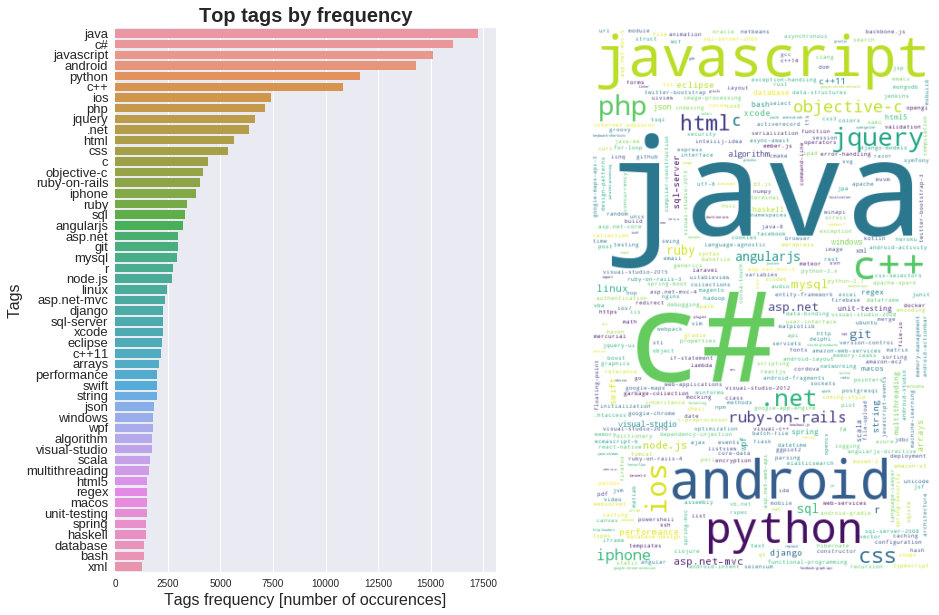

In [46]:
# Graph top tags

# inputs
top_n = 50   # number of tag to display
df_1 = pd.DataFrame(all_tags.most_common(), columns=["tags","freq_all"])

#plot
fig = plt.figure(figsize=(15,10))

# hist
plt.subplot(1,2,1)
plt.title("Top tags by frequency", fontweight="bold", size=20)
sns.barplot(x= "freq_all", y= "tags", data= df_1.loc[0:top_n, :], label="Total")
plt.yticks(rotation=0, size=13)
plt.ylabel("Tags", size=16)
plt.xlabel("Tags frequency [number of occurences]", size=16)

# word cloud Graph
plt.subplot(1,2,2)
wordcloud = WordCloud(width=375,
                      height=600,
                      max_words=1628,
                      relative_scaling=1,
                      normalize_plurals=False,
                      background_color="white").generate_from_frequencies(dict(all_tags.most_common(400)))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()


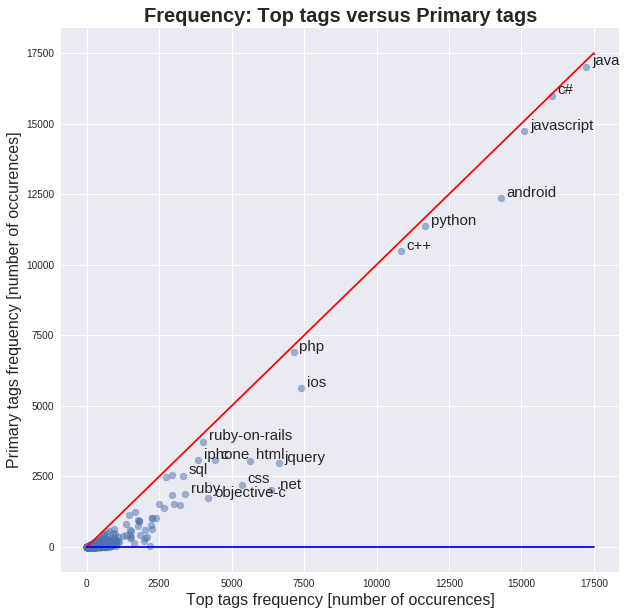

In [36]:
# Relation in-between frequency for top tags versus primary tags 

#inputs
df_2 = pd.DataFrame(primary_tags.most_common(), columns=["tags","freq_primary"])  
df = pd.merge(df_1, df_2, how="left" )

# plot
plt.figure(figsize=(10, 10))
plt.title("Frequency: Top tags versus Primary tags", fontweight="bold", size = 20)
sns.plt.scatter(x="freq_all", y="freq_primary", data=df, alpha=0.5)

# text annotations
for i in range(0,18):
    plt.annotate(df.loc[i,"tags"],
                 (df.loc[i,"freq_all"]+200, df.loc[i,"freq_primary"]+50),
                 size=15)

# unity line
u = np.linspace(0,17500,10)
plt.plot(u,u, c="red")
plt.plot(u,u*0, c="blue")
    
plt.xlabel("Top tags frequency [number of occurences]", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show() 

Tags relatively close to the red unity line are almost always primary tags, whereas the ones close to the blue line are almost never. Most commons tags are often primary and seems to correspond of popular programming languages.
For the rest we will focus the top 150 most commons tags.

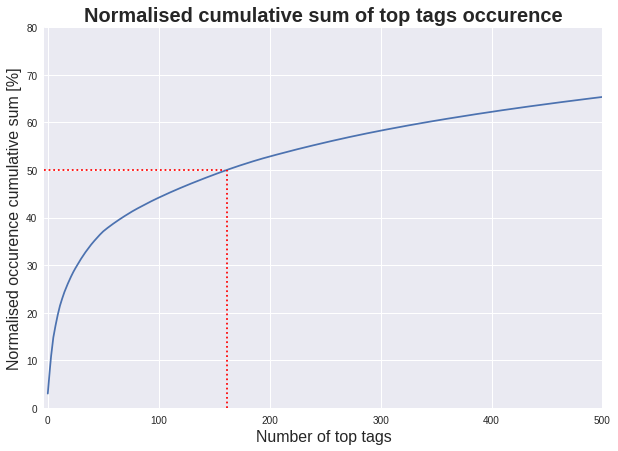

In [37]:
# Input
cumsum = 100*df.loc[:, "freq_all"].cumsum()/df["freq_all"].sum()
mask = cumsum > 50          # we want at least 50% of the occurence
n_tag = cumsum.loc[mask].argmin()
x = np.linspace(0, 500, 10)

# plot
plt.figure(figsize=(10,7))
plt.plot(cumsum)
plt.axhline(y=50, xmax=n_tag/500, color='r', linestyle=':')
plt.axvline(x=n_tag, ymax=50/80, color='r', linestyle=':')
plt.xlim(-3,500)
plt.ylim(0,80)
plt.title("Normalised cumulative sum of top tags occurence", fontweight="bold", size=20)
plt.xlabel("Number of top tags", size=16)
plt.ylabel("Normalised occurence cumulative sum [%]", size=16)
plt.show()

In [38]:
# creaton of top tag list
top_n = n_tag
top_t = list(df.loc[0:top_n-1, "tags"])

# Extra infos
count_top = df.loc[0:top_n, "freq_all"].sum()
count_all = df["freq_all"].sum()
fract_t = round(top_n/len(df),2)*100
fract_v = round(count_top/count_all,3)*100
print("The top {} tags ({}% of the tag population)\
represent {}% in term of volume/occurences.".format(top_n, fract_t, fract_v))

The top 162 tags (1.0% of the tag population)represent 50.1% in term of volume/occurences.


### 1.2 Corpus processing
In this section we clean and explore the corpus (body columns).
We will extract nouns or adjectives that are not in a stopword list.
for caculation reason we limit the extraction of 10000 document. The most frequent words do not change with more documents.

In [39]:
# stopwords

# standard stopwords list from nltk library    
stopwords = set(nltk.corpus.stopwords.words("english"))

# updated with some specific words found in the corpus
stopwords.update(["p","/p","way","=","something", "anyone", "possible", "good", 
"example", "question", "solution", "able", "different", "first", 'following', 
"anything", 'help', 'thing','sure', 'many', 'lot', 'much', "several", "wrong", 
"right", "idea", "easy", "everything", "difference", "|", "certain", "kind", 
"great", "nothing", "answer", "please", "little", "/", r"\&gt", "+", "..", 
"specific", "code", "new", "name", "error", "use", "file", "work", "value", 
"ok", "true", "end", "false"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# build word list frequency
all_words = nltk.FreqDist()
for body in corpora.sample(10000, random_state=0):
    tokenized_body = process_content(body, stopwords)
    for w in tokenized_body:
        all_words[w] += 1 
        
print("{} words have been extracted".format(len(all_words)))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
66029 words have been extracted


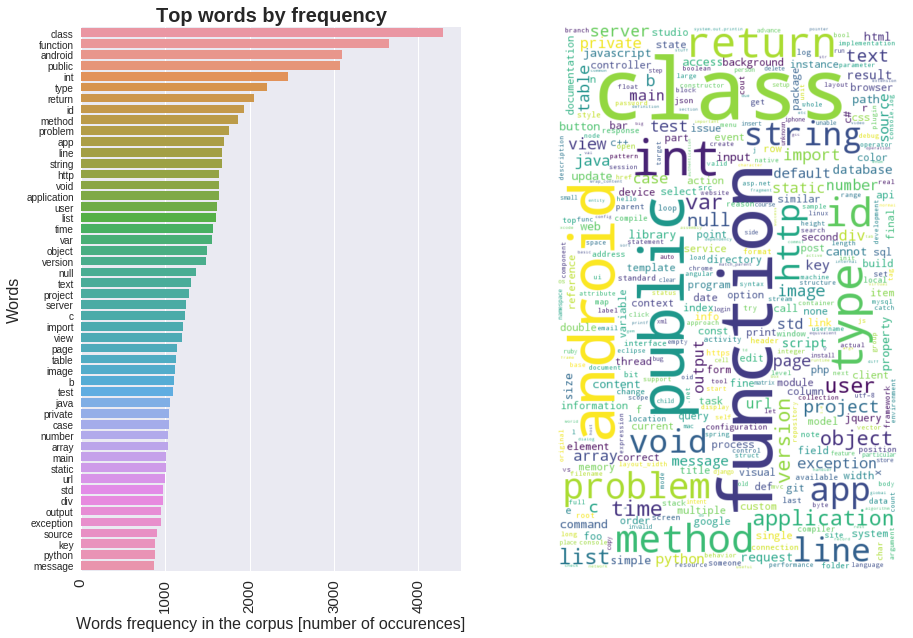

In [43]:
# Graph top words

# inputs
top_n = 50   # number of top words to display
df = pd.DataFrame(all_words.most_common(top_n), columns=["words","freq"])

# plot
fig = plt.figure(figsize=(15,10))

# hist
plt.subplot(1,2,1)
plt.title("Top words by frequency", fontweight="bold", size=20)
plt.xticks(rotation=90, size=15)
sns.barplot(x="freq", y="words", data=df.loc[0:top_n, :], label="Total");
plt.ylabel("Words", size=16)
plt.xlabel("Words frequency in the corpus [number of occurences]", size=16)

# word cloud Graph
plt.subplot(1,2,2)
wordcloud = WordCloud(width=500,
                      height=800,
                      max_words=1628,
                      relative_scaling=1,
                      normalize_plurals=False,
                      background_color="white").generate_from_frequencies(dict(all_words.most_common(400)))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

## 2 Unsupervised models

In this section,  we will explore Latent Dirichlet allocation (LDA), with different parametrization and input tables. Based on our corpus and list of most commons words, we will create tables that can be used as input for our models:
- TF Term Frequency table: for each documents (row) we will compute the frequency of the most frequent words (columns)
- TF-IDF Term Frequency - Inverse Document Frequency: The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. This help to reduce the importance of the very commons words. More information [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)  

We will test both kind of tables on different sizes. To assess the different approach we will use our own scoring: "hit rate" (see topic_score() in [NLP_function.py](https://github.com/Umercia/NLP_Stackoverflow/blob/master/NLP_functions.py)). For each post, we define the  hit rate as the ratio of the number of real tags found by the model and the number of real tags. By default only tags in our top tags list are considered (162 tags).  
We will conduct a kind a of grisearch on the number of topics and the number of feature provided to construct the tf or tfidf.

In [0]:
## grid search for LDA  (25 min per loop ==> 4h40 )

t0 = time()

topic_size = [15, 25, 35]
max_features = [600, 800, 1000, 1200]

## grid results arrays
grid_score_lda_tfidf = pd.DataFrame(0, index=max_features, columns=topic_size) 
grid_score_lda_tfidf.index.name = "max_features"
grid_score_lda_tfidf.columns.name = "topic_siz"
grid_score_lda_tf = grid_score_lda_tfidf.copy()

for f in max_features:
    
    # feature selection with the vocabulary list
    voca = vocabulary(all_words, all_tags, f, 1)
    
    # tfidf
    tfidf_vectorizer = TfidfVectorizer(vocabulary=voca,
                                       token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")
    tfidf = tfidf_vectorizer.fit_transform(corpora)
    
    # tf
    tf_vectorizer = CountVectorizer(vocabulary=voca,
                                    token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")
    tf = tf_vectorizer.fit_transform(corpora)

    feature_names = tfidf_vectorizer.get_feature_names()


    for t in topic_size:
        
        # LDA-tfidf
        lda_tfidf = LatentDirichletAllocation(n_components=t, 
                                random_state=0).fit(tfidf)
        grid_score_lda_tfidf.loc[f, t] = topic_score(lda_tfidf, 
                                                      tfidf, 
                                                      feature_names, 
                                                      top_t, 
                                                      document_tags)
        # LDA-tf
        lda_tf = LatentDirichletAllocation(n_components=t, 
                                random_state=0).fit(tf)
        grid_score_lda_tf.loc[f, t] = topic_score(lda_tf, 
                                                      tf, 
                                                      feature_names, 
                                                      top_t, 
                                                      document_tags)
        
        print(round((time() - t0)/60,0), "min | iteration: max_feature=", f," | topic_sise=", t)
        print("tfidf score =", grid_score_lda_tfidf.loc[f, t])
        print("tf score =", grid_score_lda_tf.loc[f, t])
        t0 = time()

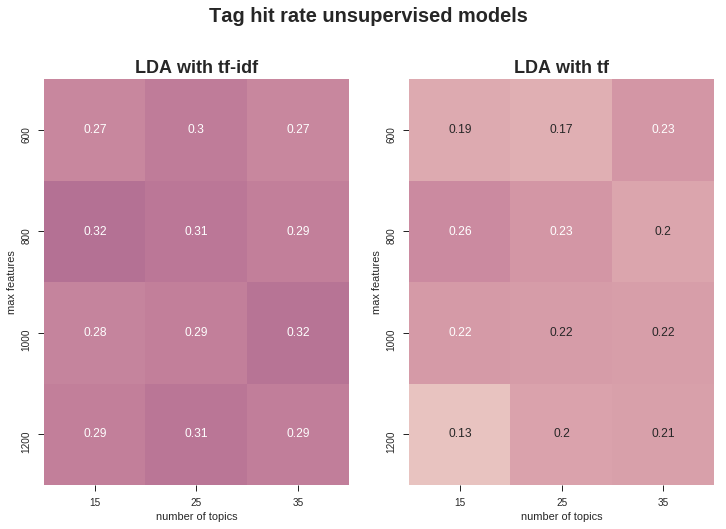

In [0]:
# plot grid search results 

# inputs
grid_scores = [grid_score_lda_tfidf, grid_score_lda_tf] 
titles = ["LDA with tf-idf", "LDA with tf" ]     
param_names = ["n_components", "max_features"]
param_values = [grid_score_lda_tfidf.columns, grid_score_lda_tfidf.index]

# plot
sns.set(style="ticks", palette="pastel")
fig = plt.figure(figsize=(12,8))
fig.suptitle("Tag hit rate unsupervised models", fontweight="bold", size=20)
for i,grid_score in enumerate(grid_scores):
    plt.subplot(1,2,i+1) 
    sns.heatmap(grid_score, 
                square=True, 
                annot=True, 
                cbar=False,
                vmin=0.03,
                vmax=0.6,
                xticklabels=param_values[0],
                yticklabels=param_values[1])
    plt.title(titles[i], fontweight="bold",size = 18)
    plt.xlabel("number of topics")
    plt.ylabel("max features");

Best hit rate of 32%: LDA tfidf with 800 features with 15 topics






In [48]:
# final unsupervised model: 800 words, tf, LDA, 15 topics 

t0 = time()

voca = vocabulary(all_words, all_tags, 800, 1)

# tfidf
tfidf_vectorizer_uns = TfidfVectorizer(vocabulary=voca,
                                   token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")
tfidf_uns = tfidf_vectorizer_uns.fit_transform(corpora)

#LDA
lda_tfidf_uns = LatentDirichletAllocation(n_components=15, 
                                  random_state=0).fit(tfidf_uns)

# save model
joblib.dump(tfidf_vectorizer_uns, "tfidf_vectorizer_uns.gz")
joblib.dump(lda_tfidf_uns, "lda_tfidf_uns.gz")

print("Done in: ", round((time() - t0)/60,0), " min")

Done in:  5.0  min


In [53]:
# topics from the model
display_topics2(lda_tfidf_uns, tfidf_vectorizer_uns.get_feature_names(), n_top_words=10)

,0,1,2,3,4,5,6,7,8,9
Topic0,android,app,ios,device,activity,iphone,application,xcode,intent,view
Topic1,view,event,window,button,wpf,control,keyboard,user,click,one
Topic10,std,int,c++,date,const,function,struct,template,operator,#include
Topic11,git,command,python,directory,line,script,run,install,folder,repository
Topic12,server,http,user,web,api,request,service,client,application,php
Topic13,array,memory,int,n,thread,loop,number,size,time,string
Topic14,function,var,data,url,return,console.log,json,javascript,get,request
Topic2,public,class,string,method,object,void,private,static,return,null
Topic3,@,self,swift,nil,scala,language,objective-c,programming,class,let
Topic4,x,b,c,string,r,list,python,foo,f,function


In [8]:
# plot with PyLDAvis library
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf_uns, tfidf, tfidf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
12     -57.639767  243.196106       1        1  9.132378
2       28.988270   64.442261       2        1  8.656144
8     -266.583954  241.034805       3        1  7.278654
11     177.237152  199.515900       4        1  7.249598
14      75.021164 -136.084534       5        1  6.651729
13     142.222549 -318.787445       6        1  6.639886
4       83.823318  375.186096       7        1  6.604356
9      198.313568   -2.112812       8        1  6.588216
5     -333.296417    5.213409       9        1  6.521570
7      -99.402527  -96.056641      10        1  6.332077
0     -265.748627 -199.567444      11        1  6.313450
6     -153.606888   74.221710      12        1  6.198624
10     309.136566 -166.252991      13        1  5.938590
1      364.793396   99.142349      14        1  5.293172
3      -73.728477 -301.417633      15        1  4.601557, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
274   Default  3544.000000      android  3544.000000  30.0000  30.0000
138   Default  3151.000000       public  3151.000000  29.0000  29.0000
87    Default  1457.000000          std  1457.000000  28.0000  28.0000
330   Default  3181.000000          int  3181.000000  27.0000  27.0000
482   Default  1357.000000          git  1357.000000  26.0000  26.0000
781   Default  1710.000000          div  1710.000000  25.0000  25.0000
535   Default  1359.000000          sql  1359.000000  24.0000  24.0000
716   Default  1888.000000        table  1888.000000  23.0000  23.0000
461   Default  4797.000000     function  4797.000000  22.0000  22.0000
573   Default  2363.000000        array  2363.000000  21.0000  21.0000
695   Default  1161.000000            @  1161.000000  20.0000  20.0000
36    Default  4754.000000        class  4754.000000  19.0000  19.0000
90    Default  2569.000000            x  2569.000000  18.0000  18.0000
702   Default  1249.000000       visual  1249.000000  17.0000  17.0000
305   Default  1179.000000          css  1179.000000  16.0000  16.0000
363   Default  2955.000000          app  2955.000000  15.0000  15.0000
100   Default  1137.000000      eclipse  1137.000000  14.0000  14.0000
510   Default  1419.000000       studio  1419.000000  13.0000  13.0000
291   Default  1654.000000         html  1654.000000  12.0000  12.0000
213   Default  1623.000000       jquery  1623.000000  11.0000  11.0000
633   Default  2563.000000      project  2563.000000  10.0000  10.0000
409   Default  1373.000000        query  1373.000000   9.0000   9.0000
293   Default  1657.000000     database  1657.000000   8.0000   8.0000
328   Default  2589.000000          var  2589.000000   7.0000   7.0000
227   Default  2063.000000            b  2063.000000   6.0000   6.0000
565   Default  4575.000000       string  4575.000000   5.0000   5.0000
178   Default  2274.000000       python  2274.000000   4.0000   4.0000
9     Default  1682.000000       select  1682.000000   3.0000   3.0000
474   Default  1009.000000         /div  1009.000000   2.0000   2.0000
32    Default  1437.000000          c++  1437.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
237   Topic15   263.144586         func   484.657355   2.4680  -4.6278
737   Topic15   164.259559     protocol   305.147384   2.4594  -5.0991
259   Topic15   230.648841          val   448.427910   2.4139  -4.7597
358   Topic15   233.590199         init   457.383119   2.4068  -4.7470
220   Topic15   312.509795  programming   710.032759   2.2581  -4.4559
613   Topic15   240.432417        video   574.315097   2.2080  -4.7181
740   Topic15   355.509533     language   919.733033   2.1282  -4.3270
646   Topic15   116.414421        super   310.450354   2.0979  -5.4434
457   Topic15   189.845396         cell   510.598364   2.0894  -4.9543
731   

## 3 Semi-supervised-models
In this section, we have a very similar approach than the previous 100% unsurpervised approach. But rather than providing top words as input features for tf and tfidf, we will provide top 162 tags. The models will just focus on the frequency of those tags in the corpus.
We will conduct a kind a of grisearch on the number of topics and the learning decay.

In [0]:
## grid search for  LDA tf and tfidf semi-supervised with tags names
t0 = time()

# define search parameters
param_1 = [15,25,35, 45]
param_2 = [0.5, 0.7, 0.9]
param_1_name = "n_components"
param_2_name = "Learning_decay"
voca = vocabulary(all_words, all_tags, 1, 162)  # semi-supervised here

## grid results array
grid_score_lda_tfidf_sem = pd.DataFrame(0, 
                                    index=param_1, 
                                    columns=param_2) 
grid_score_lda_tfidf_sem.index.name = param_1_name
grid_score_lda_tfidf_sem.columns.name = param_2_name
grid_score_lda_tf_sem = grid_score_lda_tfidf_sem.copy()

   
# tfidf
tfidf_vectorizer_sem = TfidfVectorizer(vocabulary=voca,
                                   token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")
tfidf_sem = tfidf_vectorizer_sem.fit_transform(corpora)
    
# tf
tf_vectorizer_sem = CountVectorizer(vocabulary=voca,
                                token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")
tf_sem = tf_vectorizer_sem.fit_transform(corpora)

feature_names = tfidf_vectorizer_sem.get_feature_names()


for i in param_1:
    for j in param_2:
        
        # LDA-tfidf
        lda_tfidf_sem = LatentDirichletAllocation(n_components=i,
                                              learning_decay=j,
                                              random_state=0).fit(tfidf_sem)
        grid_score_lda_tfidf_sem.loc[i, j] = topic_score(lda_tfidf_sem, 
                                                      tfidf_sem, 
                                                      feature_names, 
                                                      top_t, 
                                                      document_tags)
        # LDA-tf
        lda_tf_sem = LatentDirichletAllocation(n_components=i,
                                           learning_decay=j, 
                                           random_state=0).fit(tf_sem)
        grid_score_lda_tf_sem.loc[i, j] = topic_score(lda_tf_sem, 
                                                  tf_sem, 
                                                  feature_names, 
                                                  top_t, 
                                                  document_tags)
        
        print(time() - t0,"  |", param_1_name,  " = ", i,"  | ",  param_2_name, " = ", j)
        print("tfidf score =", grid_score_lda_tfidf_sem.loc[i, j])
        print("tf score =", grid_score_lda_tf_sem.loc[i, j])
        t0 = time()

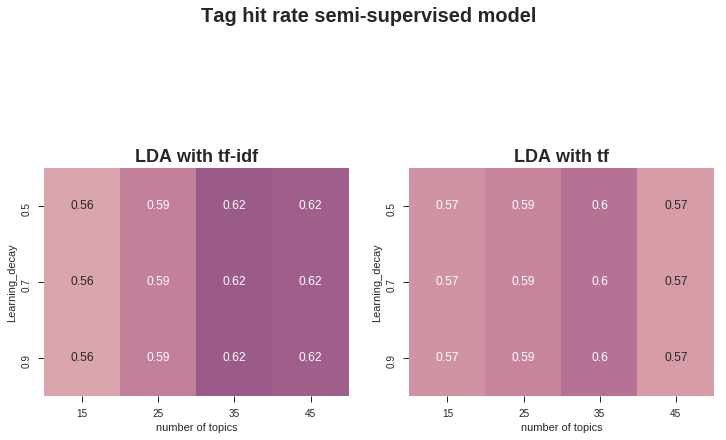

In [0]:
# plot gridsearch results

# inputs
grid_scores = [grid_score_lda_tfidf_sem,  grid_score_lda_tf_sem] 
titles = ["LDA with tf-idf", "LDA with tf" ]            

# plot
sns.set(style="ticks", palette="pastel")
fig = plt.figure(figsize=(12,8))
fig.suptitle("Tag hit rate semi-supervised model", fontweight="bold", size=20)
for i,grid_score in enumerate(grid_scores):
    plt.subplot(1,2,i+1) 
    sns.heatmap(grid_score, 
                square=True, 
                annot=True, 
                cbar=False,
                vmin=0.5,
                vmax=0.7,
                xticklabels=param_values[0],
                yticklabels=param_values[1])
    plt.title(titles[i], fontweight="bold",size = 18)
    plt.xlabel("number of topics")
    plt.ylabel("Learning_decay");

Best hit rate of 62%: LDA-tfidf  with 35 topics (learning decay do not have influence).

In [56]:
# final unsupervised model: 35 topics 
t0 = time()

#LDA
lda_tfidf_sem = LatentDirichletAllocation(n_components=35, 
                                  random_state=0).fit(tfidf_sem)

# save model
joblib.dump(tfidf_vectorizer_sem, "tfidf_vectorizer_sem.gz")
joblib.dump(lda_tfidf_sem, "lda_tfidf_sem.gz")

print("Done in: ", round((time() - t0)/60,0), " min")

Done in:  3.0  min


In [63]:
display_topics2(lda_tfidf_sem, list(vocabulary(all_words, all_tags, 1, 162)), n_top_words=10).head(10)

,0,1,2,3,4,5,6,7,8,9
Topic0,api,testing,gcc,templates,rest,class,http,function,file,list
Topic1,iphone,spring,hibernate,class,vb.net,enums,string,file,security,xml
Topic10,linux,bash,html5,qt,windows,file,shell,ubuntu,function,python
Topic11,memory,security,linq,gradle,file,list,class,android,c,go
Topic12,c#,ruby,facebook,reflection,class,file,string,api,list,.net
Topic13,javascript,html,angular,function,jquery,http,file,class,css,string
Topic14,date,rest,authentication,excel,ios7,string,file,tsql,function,http
Topic15,asp.net,debugging,forms,ssl,pandas,file,windows,http,authentication,.net
Topic16,django,node.js,class,oop,python,file,templates,function,database,http
Topic17,algorithm,ajax,github,shell,lambda,function,cocoa,file,macos,jquery


In [5]:
# topics exploration with PyLDAvis library
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf_sem, tfidf_sem, tfidf_vectorizer_sem, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
32      27.620403   -8.443931       1        1  4.893814
27      50.115784  -51.041660       2        1  4.853717
30      17.250824  -47.991982       3        1  4.386053
33     -77.030785   17.045597       4        1  4.098839
28     -39.047966 -102.439369       5        1  3.875724
13    -100.164268   41.171925       6        1  3.744749
22     -12.636076  -26.628504       7        1  3.615900
21      93.568398   92.762390       8        1  3.193730
4      -33.257721  120.114685       9        1  3.146813
29      22.864429 -106.681961      10        1  3.135386
26     -42.600487   39.653275      11        1  3.050154
31    -130.082153   62.803772      12        1  2.992320
34      28.188206   31.424583      13        1  2.950662
0     -112.943520  -49.785103      14        1  2.946700
12      15.786052  130.834030      15        1  2.884765
5      104.877602   -5.028046      16        1  2.753208
23     -75.578117  -81.969284      17        1  2.750966
6       16.291492   72.398987      18        1  2.688891
8      -27.173609   75.203217      19        1  2.641103
15      61.683018   19.128176      20        1  2.638701
9     -116.340004   -8.314357      21        1  2.603477
14     -69.316467  -26.086094      22        1  2.599797
17      59.113743   60.063675      23        1  2.591380
11      -5.585079  -78.001579      24        1  2.523992
7      -68.305550  127.601730      25        1  2.501790
10      54.539814  101.327950      26        1  2.314707
1      -67.710724   74.263176      27        1  2.292423
19      -3.448328    5.399396      28        1  2.279124
25     106.499977   42.727940      29        1  2.011438
24      68.346603  -91.197090      30        1  1.985565
16      65.482666  -20.516117      31        1  1.951953
2      -10.090323   43.354740      32        1  1.942156
18     109.637527  -57.582748      33        1  1.798587
20     -36.890427  -53.253689      34        1  1.745217
3      -42.080006   -3.316420      35        1  1.616198, topic_info=     Category          Freq                    Term         Total  loglift  \
term                                                                         
64    Default   6710.000000                 android   6710.000000  30.0000   
140   Default   9783.000000                  string   9783.000000  29.0000   
75    Default  11245.000000                function  11245.000000  28.0000   
148   Default   7584.000000                    http   7584.000000  27.0000   
157   Default   5717.000000                    java   5717.000000  26.0000   
87    Default   4462.000000                   image   4462.000000  25.0000   
144   Default   5993.000000                       c   5993.000000  24.0000   
81    Default   3327.000000             performance   3327.000000  23.0000   
42    Default  11818.000000                   class  11818.000000  22.0000   
35    Default   3585.000000                     c++   3585.000000  21.0000   
124   Default   3673.000000                     sql   3673.000000  20.0000   
139   Default   3608.000000                     php   3608.000000  19.0000   
16    Default   3955.000000               exception   3955.000000  18.0000   
154   Default   3743.000000                     api   3743.000000  17.0000   
78    Default   3017.000000                       r   3017.000000  16.0000   
21    Default   3613.000000                      c#   3613.000000  15.0000   
133   Default   3871.000000              javascript   3871.000000  14.0000   
142   Default   2865.000000                   types   2865.000000  13.0000   
147   Default   3007.000000                  memory   3007.000000  12.0000   
96    Default   3001.000000                     ios   3001.000000  11.0000   
84    Default   3926.000000                database   3926.000000  10.0000   
10    Default   3352.000000                  jquery   

## 4 Supervised-models
In this section we will explore two supervised classification models: Random Forest and Logistic Regression. Since it is supervised we will now provides the tags of each post (the format is a 162 tags one hot encoded matrix). Since it is a multilabels modelisation,  we will wrape our models with [ MultiOutputClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html).  
As usual for supervised model we will split the sample into train and test sets.
Furthermore, for computing time reduction in the grid search, we will sub-sample the train set again.
We will use a kind of stratifier function (see strat_binary_multilabels() in [NLP_function.py](https://github.com/Umercia/NLP_Stackoverflow/blob/master/NLP_functions.py)) that will select at least 350 occurence of each tags.
 


In [57]:
# redefinition of the vocabulary: top 800 words + top 162 tags
voca = vocabulary(all_words, all_tags, 800, 162)  

# split and format corpora
X, Y = raw2XY(text_df, top_t, voca)
idx_test = text_df.sample(20000, random_state=0).index    

idx_train = text_df.drop(idx_test).index  # reverse selection


X_train, Y_train = raw2XY(text_df.loc[idx_train, :], 
                                  tags_list=top_t, 
                                  vocab_list=voca)

X_test, Y_test = raw2XY(text_df.loc[idx_test, :], 
                                tags_list=top_t, 
                                vocab_list=voca)

# for the gridsearch we will subsample the train set with at least 350 ocurences 
# per tag.
idx_train_grd = strat_binary_multilabels(Y.loc[idx_train,:], min_occurences=350)  
idx_test_grd = text_df.loc[idx_train,:].drop(idx_train_grd).sample(20000, random_state=0).index

X_train_grd, Y_train_grd = raw2XY(text_df.loc[idx_train_grd, :], 
                                  tags_list=top_t, 
                                  vocab_list=voca)

X_test_grd, Y_test_grd = raw2XY(text_df.loc[idx_test_grd, :], 
                                tags_list=top_t, 
                                vocab_list=voca)

print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("")
print("Grid search sub-sample:")
print("X_test_grd.shape:", X_test_grd.shape)
print("Y_test_grd.shape:", Y_test_grd.shape)
print("X_train_grd.shape:", X_train_grd.shape)
print("Y_train_grd.shape:", Y_train_grd.shape)

X_test.shape: (20000, 883)
Y_test.shape: (20000, 162)
X_train.shape: (166817, 883)
Y_train.shape: (166817, 162)

Grid search sub-sample:
X_test_grd.shape: (20000, 883)
Y_test_grd.shape: (20000, 162)
X_train_grd.shape: (35753, 883)
Y_train_grd.shape: (35753, 162)


In [0]:
# grid search for RF  // 4.4 hrs //

# define search parameters
max_depth_l = [5, 10, 15]
criterion_l = ["gini", "entropy"]

# grid results array
grid_score_rf_tf = pd.DataFrame(0, index=max_depth_l, columns=criterion_l) 
grid_score_rf_tf.index.name = "max_depth_l"
grid_score_rf_tf.columns.name = "criterion_l"

t0 = time()
for d in max_depth_l:
    for c in criterion_l:
        
        # RF-TF
        rf_tf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100,
                                                             max_depth=d,
                                                             criterion=c,
                                                             n_jobs=-1))
        rf_tf.fit(X_train_grd, Y_train_grd)
        
        # scoring                          
        Y_pred_rf = supervised_predict(rf_tf, 
                                       X_test_grd, 
                                       features=Y_test_grd.columns, 
                                       n_words=10)
        
        grid_score_rf_tf.loc[d, c] = (Y_pred_rf*Y_test_grd).sum().sum()/Y_test_grd.sum().sum()                                     
        
        print(time() - t0, "  | iteration: max_depth_l=", d,"  | criterion_l=", c, "  | score=", grid_score_rf_tf.loc[d, c])
        t0 = time()

In [0]:
## grid search for Logistic Regression homemade scoring // 3.5 hrs //

# define search parameters
C_l = np.logspace(-2,2,3)
penalty_l = ["l1", "l2"]

# grid results array
grid_score_logi_tf = pd.DataFrame(0, index=C_l, columns=penalty_l) 
grid_score_logi_tf.index.name = "C_l"
grid_score_logi_tf.columns.name = "penalty_l"

t0 = time()
for c in C_l:
    for p in penalty_l:
        
        # Logistic regression-TF
        logi_reg_tf = MultiOutputClassifier(LogisticRegression(C=c,
                                                               penalty=p,
                                                               n_jobs=-1))
        logi_reg_tf.fit(X_train_grd, Y_train_grd)
        
        # Scoring                          
        Y_pred_logi = supervised_predict(logi_reg_tf, 
                                         X_test_grd, 
                                         features=Y_test_grd.columns, 
                                         n_words=10)
        grid_score_logi_tf.loc[c, p] = (Y_pred_logi*Y_test_grd).sum().sum()/Y_test_grd.sum().sum()                                     
        
        print(time() - t0, "  | iteration: C_l=", c,"  | penalty_l=", p, "  | score=", grid_score_logi_tf.loc[c, p])
        t0 = time()

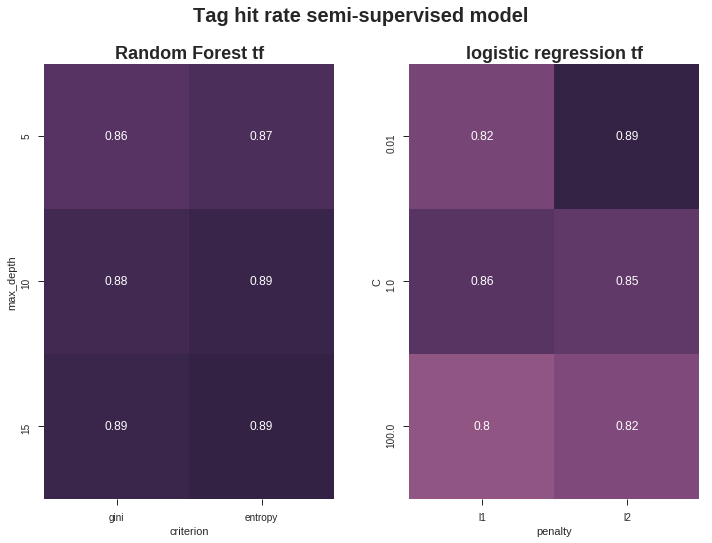

In [0]:
# plot results

# inputs
grid_scores = [grid_score_rf_tf, grid_score_logir_tf ]   
titles = ["Random Forest tf", "logistic regression tf"]           

# plot
sns.set(style="ticks", palette="pastel")
fig = plt.figure(figsize=(12,8))
fig.suptitle("Tag hit rate semi-supervised model", fontweight="bold", size=20)
for i,grid_score in enumerate(grid_scores):
    plt.subplot(1,2,i+1) 
    sns.heatmap(grid_score, 
                square=True, 
                annot=True, 
                cbar=False,
                vmin=0.6,
                vmax=0.9,
                xticklabels=list(grid_score.columns),
                yticklabels=list(grid_score.index))
    plt.title(titles[i], fontweight="bold",size = 18)
    plt.xlabel(grid_score.columns.name)
    plt.ylabel(grid_score.index.name);

Both models can reach a hit rate of 89%. We will now train both models with all data and check again the hit rate.

In [0]:
# Model with optimized parameters and train with all the train dataset // 2 hrs //
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from time import time

t0 = time()
rf_tf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100,
                                                             max_depth=15,
                                                             criterion="entropy",
                                                             n_jobs=-1))
rf_tf.fit(X_train, Y_train)   #
Y_pred_rf = supervised_predict(rf_tf, X_test, labels=Y_test.columns, n_words=10)
score_rf_tf = (Y_pred_rf*Y_test).sum().sum()/Y_test.sum().sum()  

print(time() - t0, "  | score=", score_rf_tf)

7443.384118318558   | score= 0.7963959898133522


In [0]:
# Model with optimized parameters and train with all the train dataset // 20 min //
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from time import time

t0 = time()

logi_reg_tf = MultiOutputClassifier(LogisticRegression(C=0.01,
                                                       penalty="l2",
                                                       n_jobs=-1))
logi_reg_tf.fit(X_train, Y_train)

# Scoring                          
Y_pred_logi = supervised_predict(logi_reg_tf, X_test, labels=Y_test.columns, n_words=10)
score_logi_tf = (Y_pred_logi*Y_test).sum().sum()/Y_test.sum().sum()       


print(time() - t0, "  | score=", score_logi_tf)

2479.0070548057556   | score= 0.8918004254496229


In [0]:
# save final supervised logistic regression with C=0.01 and penalty="l2" 

voca_list = vocabulary(all_words, all_tags, 800, 162) 
corpus_vectorizer_sup = CountVectorizer(vocabulary=vocab_list,
                                      token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")

joblib.dump(logi_reg_tf, "logi_reg_tf.gz")
joblib.dump(corpus_vectorizer_sup, "tf_800_162.gz")

['tf_800_162.gz']

In [0]:
# save top 162 tags
import csv

with open('top_t_162.csv', 'w') as f:
    wr = csv.writer(f, quoting=csv.QUOTE_ALL)
    wr.writerow(top_t)

## 5 Conclusion

---



Supervised model score better than unsupervised on the selected tags list.  
However, unsupervide models can create new tags that can be relevant in some cases.

API using the selected logistic regression (supervised) and LDA (unsupervised) can be find [here](http://umercia.pythonanywhere.com/)

    
Good ressources: 
- [machinelearningplus](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) 
- [towardsdatascience](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)